2018/05/10

# CS236605: Deep Learning
# Homework 1

## Aviv Rosenberg, 300798055
### avivr@cs.technion.ac.il

### Section 1

We have trained a ResNet18 and VGG16 model with three optimizer configurations:
 - SGD, `learn_rate=0.1`, `momentum=0.9`
 - SGD without momentum, `learn_rate=0.1`
 - Adam, `learn_rate=0.1`
 
The output for both models in each configuration was serialized to JSON after all epochs were completed.
The training code can be found [here](https://github.com/avivrosenberg/pytorch-cifar/blob/hw1/main.py) (modified from the original version).

We will load the JSON files and plot the accuracy and loss over the train and test sets in each configuration.

In [1]:
import json

def load_data(output_files):
    data = []
    for output_file in output_files:
        with open(output_file, mode='r', encoding='utf-8') as f:
            data += json.load(f)
    return data

def get_model_results(data, model_name):
    for d in data:
        if d['model'].lower() == model_name.lower():
            yield d


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import itertools


DISP_LABELS = {
    'train': 'Train',
    'test': 'Test',
    'acc': 'Accuracy (%)',
    'loss': 'Loss (n.u.)'
}

FIG_WIDTH = 12
FIG_HEIGHT = 9

def plot_model_results(model_results):
    model_results = list(model_results)
    model_name = model_results[0]['model']

    fig = plt.figure()

    prod = itertools.product(('train', 'test'), ('acc', 'loss'))
    for i, (train_test, acc_loss) in enumerate(prod):
        ax = fig.add_subplot(2, 2, i+1)
        plot_single_case(ax, train_test, acc_loss, model_results)
    
    fig.set_size_inches(FIG_WIDTH, FIG_HEIGHT, forward=True)
    fig.suptitle(model_name)
    fig.tight_layout(pad=2.5)
    
    return fig
    
    
def plot_single_case(ax, train_test, acc_loss, model_results):
    data_type = f'{train_test}_{acc_loss}'
    for curr_result in model_results:
        optimizer_name = curr_result['optimizer']['name']
        optimizer_params = curr_result['optimizer']['params']
        
        if optimizer_name == 'SGD':
            optimizer_label = f"SGD(lr={optimizer_params['lr']}, " \
                              f"mtm={optimizer_params['momentum']})"
        else:
            optimizer_label = f"{optimizer_name}(lr={optimizer_params['lr']})"
        
        data = np.array(curr_result[data_type])
        epochs = data[:, 0]
        values = data[:, 1]
        
        ax.plot(epochs, values, label=optimizer_label)
        ax.set_xlabel("Epoch")
        ax.set_ylabel(f"{DISP_LABELS[train_test]} {DISP_LABELS[acc_loss]}")
        ax.legend()
        ax.grid()


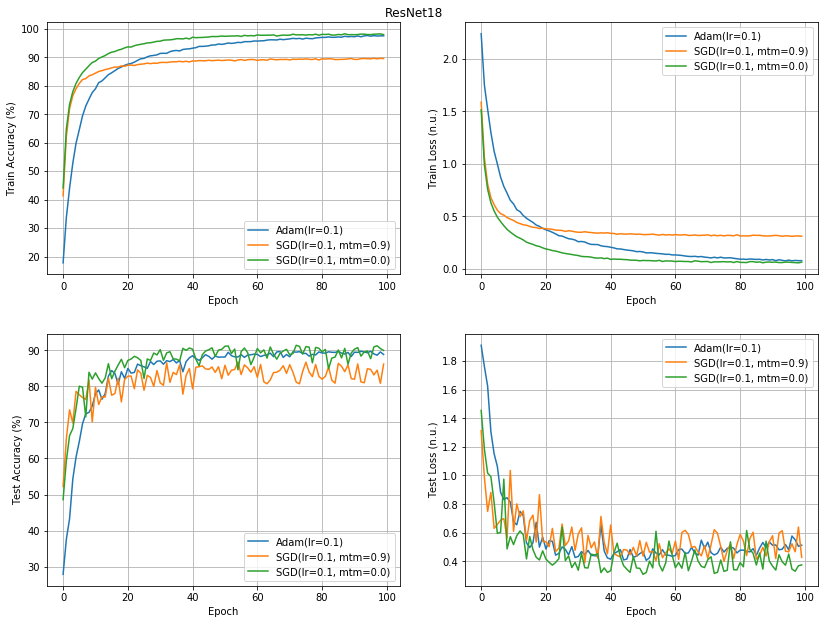

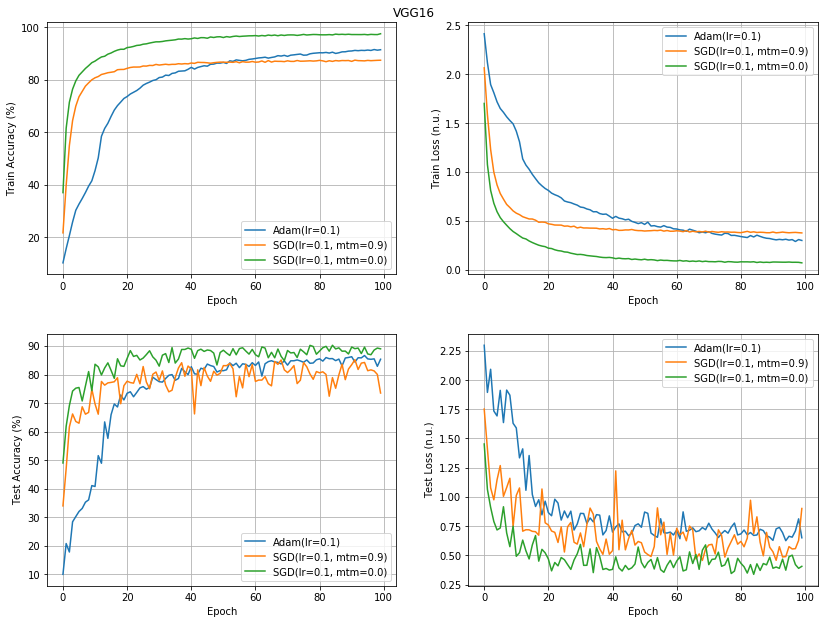

In [12]:
data = load_data([
    'out/out-adam.json',
    'out/out-sgd-momentum.json',
    'out/out-sgd-vanilla.json'
])

for model_name in ['ResNet18', 'VGG16']:
    model_results = get_model_results(data, model_name)
    fig = plot_model_results(model_results)
    fig.savefig(f"out/{model_name}.pdf")


### Section 2 - Fine Tuning

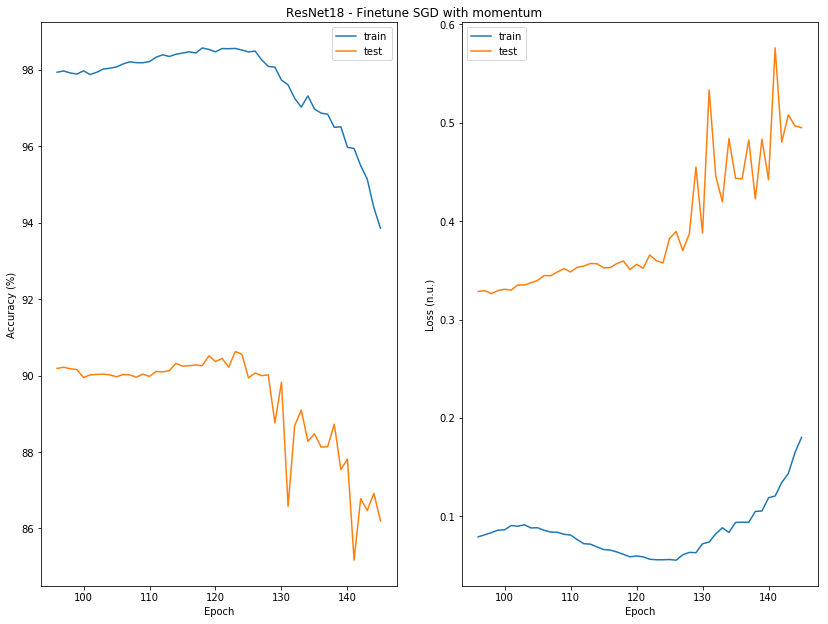

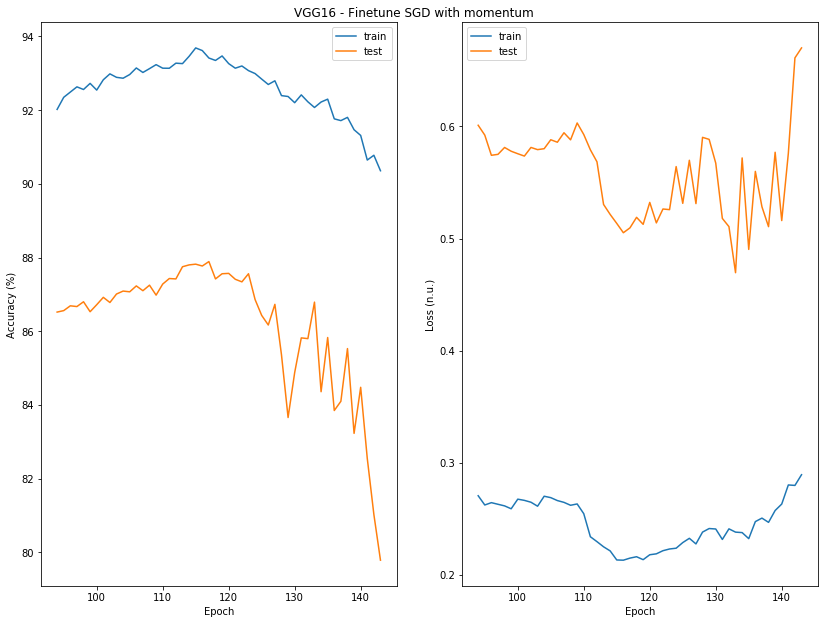

In [14]:
data_resumed = load_data([
    'out/ResNet18-SGD_0.05_0.90-resume.json',
    'out/VGG16-SGD_0.05_0.90-resume.json'
])


def plot_finetune_results(model_results):
    model_results = list(model_results)
    model_name = model_results[0]['model']    
    fig = plt.figure()
    
    for i, acc_loss in enumerate(['acc', 'loss']):
        ax = fig.add_subplot(1, 2, i+1)
        plot_single_case_finetune(ax, 'train', acc_loss, model_results)
        plot_single_case_finetune(ax, 'test',  acc_loss, model_results)
    
    fig.set_size_inches(FIG_WIDTH, FIG_HEIGHT, forward=True)
    fig.suptitle(f"{model_name} - Finetune SGD with momentum")
    fig.tight_layout(pad=2.5)
    
    return fig

def plot_single_case_finetune(ax, train_test, acc_loss, model_results):
    data_type = f'{train_test}_{acc_loss}'
    for curr_result in model_results:
        data = np.array(curr_result[data_type])
        epochs = data[:, 0]
        values = data[:, 1]
        
        ax.plot(epochs, values, label=train_test)
        ax.set_xlabel("Epoch")
        ax.set_ylabel(f"{DISP_LABELS[acc_loss]}")
        ax.legend()
        ax.grid()

for model_name in ['ResNet18', 'VGG16']:
    model_results = get_model_results(data_resumed, model_name)
    fig = plot_finetune_results(model_results)

### Section 3 - No Batch Normalization

We have modified the ResNet18 and VGG16 models by removing all batch normalizations layers. We then proceeded to train the models with the following optimizer configurations:
 - SGD, `learn_rate=0.1`, `momentum=0.9`
 - SGD without momentum, `learn_rate=0.1`
 - Adam, `learn_rate=0.001`
 
The VGG16 model failed to converge for both SGD configurations - Accuracy remains flat at 10% which is equivalent to a random guess since there are 10 classes in this dataset.
Using the Adam optimizer, the model does converge when setting a much smaller learning rate (0.001 in this case), but doesn't converge for values 1-2 orders of magnitude greater (which worked before).

For SGD, attempting to decrease the learning rate didn't help, although possibly some combination of learning rate and momentum could cause the model to converge. We can see this because it does converge with Adam, so the problem is not related to the net architecture after the change but to the steps the optimizer is making.

Batch normalization normalizes the features between the convolutional or FC layers and the non-linearities by removing mean and setting unit variance. Then, it uses parameters (which are also trained) to replace the mean and variance. This reduces the dependency on the weight initialization and hyperparemeter selection. In other words, when using batch normalization we could be more careless about the learning rate and momentum of SGD. Without it, it's much harder to find a combination that would allow the model to converge.

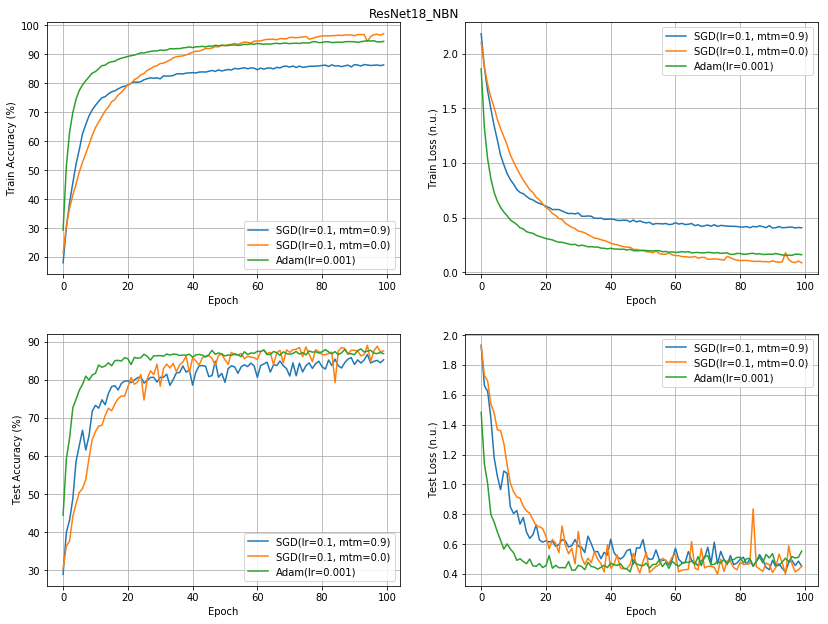

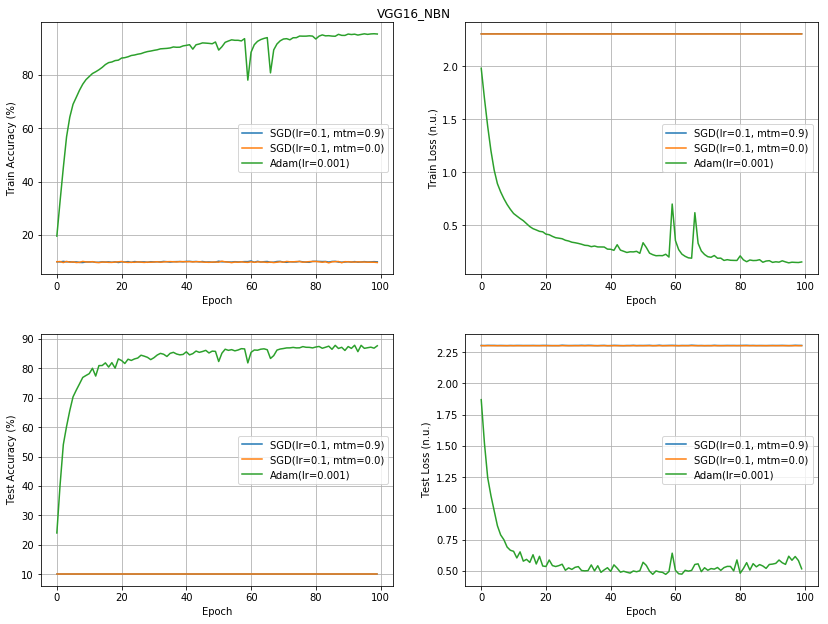

In [15]:
data_no_batchnorm = load_data([
    'out/ResNet18_NBN-SGD_0.10_0.90.json',
    'out/ResNet18_NBN-SGD_0.10_0.00.json',
    'out/ResNet18_NBN-Adam_0.00_0.90.json', #lr=0.001
    'out/VGG16_NBN-SGD_0.10_0.90.json',
    'out/VGG16_NBN-SGD_0.10_0.00.json',
    'out/VGG16_NBN-Adam_0.00_0.90.json', #lr=0.001
])

for model_name in ['ResNet18_NBN', 'VGG16_NBN']:
    model_results = get_model_results(data_no_batchnorm, model_name)
    fig = plot_model_results(model_results)